In [3]:
print(pd.read_csv("./impression_1M_50.csv", nrows=1).columns.tolist())

['user_id', 'answer_id', 'label', 'register_timestamp', 'gender', 'login_frequency', 'followers', 'topics_followed', 'questions_followed', 'answers', 'questions', 'comments', 'thanks_received', 'comments_received', 'likes_received', 'dislikes_received', 'register_type', 'register_platform', 'from_android', 'from_iphone', 'from_ipad', 'from_pc', 'from_mobile_web', 'device_model', 'device_brand', 'platform', 'province', 'city', 'question_id', 'is_anonymous', 'author_id', 'is_high_value', 'is_editor_recommended', 'has_pictures', 'has_videos', 'thanks_count', 'likes_count', 'comments_count', 'collections_count', 'dislikes_count', 'reports_count', 'helpless_count', 'answer_vector', 'question_answer', 'question_follower', 'question_invitation', 'question_comments', 'is_excellent_author', 'author_follower_count', 'is_excellent_answerer']


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

EMBED_DIM = 16
BATCH_SIZE = 1024
EPOCHS = 100
LR = 0.0001

ads = pd.read_csv("./impression_1M_50.csv")
ads = ads.sample(frac=1.0, random_state=42).reset_index(drop=True)

cat_features = [
    'user_id', 'answer_id', 'question_id', 'author_id',
    'gender', 'register_type', 'register_platform',
    'device_model', 'device_brand', 'platform',
    'province', 'city',
    'from_android', 'from_iphone', 'from_ipad',
    'from_pc', 'from_mobile_web',
    'is_anonymous', 'is_high_value', 'is_editor_recommended',
    'has_pictures', 'has_videos',
    'is_excellent_author', 'is_excellent_answerer'
]

num_features = [
    'register_timestamp', 'login_frequency',
    'followers', 'topics_followed', 'questions_followed',
    'answers', 'questions', 'comments',
    'thanks_received', 'comments_received',
    'likes_received', 'dislikes_received',
    'thanks_count', 'likes_count', 'comments_count',
    'collections_count', 'dislikes_count',
    'reports_count', 'helpless_count',
    'question_answer', 'question_follower',
    'question_invitation', 'question_comments',
    'author_follower_count'
]

for col in cat_features:
    ads[col] = LabelEncoder().fit_transform(ads[col].astype(str))

field_dims = [ads[col].nunique() for col in cat_features]
cross_idx = [0, 1]  # Placeholder indices; update based on actual interaction fields if needed

# Dummy answer vectors for demonstration purposes
# answer_vec = torch.randn(len(ads), 768)
ads['answer_vector'] = ads['answer_vector'] \
    .apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))


answer_vec = torch.tensor(
    np.stack(ads['answer_vector'].values),
    dtype=torch.float32
)


X_cat = torch.LongTensor(ads[cat_features].values)
X_num = torch.FloatTensor(ads[num_features].fillna(-1).values)
y = torch.FloatTensor(ads['label'].values)
# answer_vec = ads['answer_vector']  # Assuming provided or generated externally
# answer_vec = torch.tensor(np.stack(answer_vec.values), dtype=torch.float32)

# Train/Val/Test split
train_size = int(0.8 * len(ads))
val_size = int(0.1 * len(ads))
test_size = len(ads) - train_size - val_size

X_c_train, X_c_temp = torch.split(X_cat, [train_size, val_size + test_size])
X_n_train, X_n_temp = torch.split(X_num, [train_size, val_size + test_size])
y_train, y_temp = torch.split(y, [train_size, val_size + test_size])
vec_train, vec_temp = torch.split(answer_vec, [train_size, val_size + test_size])

X_c_val, X_c_test = torch.split(X_c_temp, [val_size, test_size])
X_n_val, X_n_test = torch.split(X_n_temp, [val_size, test_size])
y_val, y_test = torch.split(y_temp, [val_size, test_size])
vec_val, vec_test = torch.split(vec_temp, [val_size, test_size])

class RecDataset(Dataset):
    def __init__(self, cat, num, y, answer_vec):
        self.cat, self.num, self.y, self.vec = cat, num, y, answer_vec
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.cat[i], self.num[i], self.y[i], self.vec[i]

train_loader = DataLoader(RecDataset(X_c_train, X_n_train, y_train, vec_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(RecDataset(X_c_val, X_n_val, y_val, vec_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(RecDataset(X_c_test, X_n_test, y_test, vec_test), batch_size=BATCH_SIZE)




Epoch 1: Loss=0.5729, AUC=0.6093
Epoch 2: Loss=0.5668, AUC=0.6182
Epoch 3: Loss=0.5642, AUC=0.6253
Epoch 4: Loss=0.5613, AUC=0.6322
Epoch 5: Loss=0.5583, AUC=0.6389
Epoch 6: Loss=0.5553, AUC=0.6441
Epoch 7: Loss=0.5525, AUC=0.6489
Epoch 8: Loss=0.5497, AUC=0.6533
Epoch 9: Loss=0.5473, AUC=0.6553
Epoch 10: Loss=0.5449, AUC=0.6587
Epoch 11: Loss=0.5429, AUC=0.6603
Epoch 12: Loss=0.5408, AUC=0.6634
Epoch 13: Loss=0.5387, AUC=0.6640
Epoch 14: Loss=0.5372, AUC=0.6661
Epoch 15: Loss=0.5354, AUC=0.6683
Epoch 16: Loss=0.5336, AUC=0.6695
Epoch 17: Loss=0.5323, AUC=0.6698
Epoch 18: Loss=0.5308, AUC=0.6708
Epoch 19: Loss=0.5293, AUC=0.6722
Epoch 20: Loss=0.5279, AUC=0.6728
Epoch 21: Loss=0.5268, AUC=0.6736
Epoch 22: Loss=0.5253, AUC=0.6756
Epoch 23: Loss=0.5239, AUC=0.6760
Epoch 24: Loss=0.5227, AUC=0.6758
Epoch 25: Loss=0.5216, AUC=0.6760
Epoch 26: Loss=0.5204, AUC=0.6763
Epoch 27: Loss=0.5193, AUC=0.6762
Epoch 28: Loss=0.5180, AUC=0.6777
Epoch 29: Loss=0.5173, AUC=0.6772
Epoch 30: Loss=0.5158, 

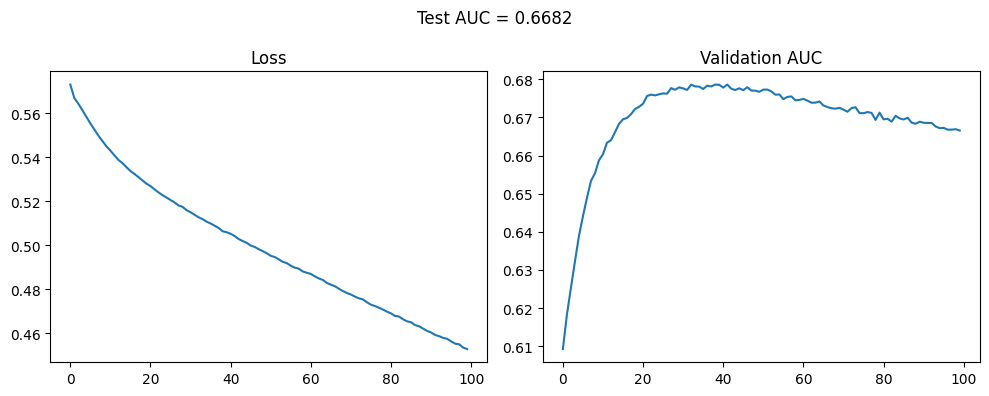

In [5]:
class FM(nn.Module):
    def forward(self, emb):
        square_sum = torch.sum(emb, dim=1)**2
        sum_square = torch.sum(emb**2, dim=1)
        return 0.5 * (square_sum - sum_square)

class DINDeepFM(nn.Module):
    def __init__(self, field_dims, cross_idx, emb_dim=EMBED_DIM , vec_dim=64,num_dim=len(num_features)):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(d, emb_dim) for d in field_dims])
        self.fm = FM()
        self.cross_idx = cross_idx
        # self.answer_proj = nn.Linear(vec_dim, emb_dim)
        self.mlp = nn.Sequential(
            # nn.Linear(emb_dim * len(field_dims) + emb_dim + 1, 128),
            # nn.Linear(emb_dim * len(field_dims) + emb_dim + len(num_features) + emb_dim, 128),
            nn.Linear((emb_dim * len(field_dims))+ len(num_features) + vec_dim, 256),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 1)
        )
        self.num_bn = nn.BatchNorm1d(num_dim)

    def forward(self, x_cat, x_num, answer_vec):
        num_norm=self.num_bn(x_num)
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        fm_out = self.fm(torch.stack([embs[i] for i in self.cross_idx], dim=1))
        # answer_vec = self.answer_proj(answer_vec.detach())
        # final = torch.cat([*embs, fm_out, x_num, answer_vec], dim=1)
        final = torch.cat([*embs,num_norm,answer_vec], dim=1)
        return self.mlp(final).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DINDeepFM(field_dims, cross_idx).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

losses, aucs = [], []
for epoch in range(EPOCHS):
    model.train(); total_loss = 0
    for xc, xn, yb, vec in train_loader:
        xc, xn, yb, vec = xc.to(device), xn.to(device), yb.to(device), vec.to(device)
        pred = model(xc, xn, vec)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()

    model.eval(); preds, labels = [], []
    with torch.no_grad():
        for xc, xn, yb, vec in val_loader:
            xc, xn, vec = xc.to(device), xn.to(device), vec.to(device)
            pred = model(xc, xn, vec)
            preds.extend(torch.sigmoid(pred).cpu().numpy())
            labels.extend(yb.numpy())
    auc = roc_auc_score(labels, preds)
    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, AUC={auc:.4f}")
    losses.append(total_loss / len(train_loader))
    aucs.append(auc)

model.eval(); test_preds, test_labels = [], []
with torch.no_grad():
    for xc, xn, yb, vec in test_loader:
        xc, xn, vec = xc.to(device), xn.to(device), vec.to(device)
        pred = model(xc, xn, vec)
        test_preds.extend(torch.sigmoid(pred).cpu().numpy())
        test_labels.extend(yb.numpy())
test_auc = roc_auc_score(test_labels, test_preds)
print(f"\n Final Test AUC: {test_auc:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(losses); plt.title("Loss")
plt.subplot(1, 2, 2); plt.plot(aucs); plt.title("Validation AUC")
plt.suptitle(f"Test AUC = {test_auc:.4f}")
plt.tight_layout(); plt.show()